In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from glob import glob
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [15]:
# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 1:
    try:
        print("Activate Multi GPU")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    except RuntimeError as e:
        print(e)

else:
    try:
        print("Activate Sigle GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
        strategy = tf.distribute.experimental.CentralStorageStrategy()
    except RuntimeError as e:
        print(e)

Activate Sigle GPU
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'


In [16]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",)(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)

    return output


def DeeplabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]), interpolation="bilinear",)(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation="bilinear",)(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return tf.keras.Model(inputs=model_input, outputs=model_output)


In [17]:
def get_file_list(path):
    images = sorted(glob(f"{path}/images/*.jpg"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    
    n_images, n_masks = len(images), len(masks)
    
    return images, masks, n_images, n_masks


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])

    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
#         image = image / 127.5 - 1

    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)

    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [18]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)

    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)

    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)

    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()
    # plt.savefig("./result.png")


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], figsize=(18, 14))

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        
        # idx = np.random.randint(len(valid_images))
        # plot_predictions([valid_images[idx]], colormap, model=model)

        plot_predictions(valid_images[:4], colormap, model=model)


In [20]:
def display_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

In [21]:
def get_images(masks):
    image_files = []
    for mask in masks:
        file_name = mask.split('/')[-1].split('.')[0]
        if os.path.isfile(f"{images}/{file_name}.jpg"):
            image_files.append(f"{images}/{file_name}.jpg")

    return image_files

In [22]:
BATCH_SIZE = 8
EPOCHS = 500
IMG_SIZE = 512
LEARNING_RATE = 0.00001
IS_SPLIT = True

In [23]:
colormap = [[0, 0, 0],
            [128, 0, 0],
            [0, 128, 0],
            [128, 128, 0],
            [0, 0, 128],
            [128, 0, 128],
            [0, 128, 128],
            [128, 128, 128],
            [64, 0, 0],
            [192, 0, 0],
            [64, 128, 0],
            [192, 128, 0],
            [64, 0, 128],
            [192, 0, 128],
            [64, 128, 128],
            [192, 128, 128],
            [0, 64, 0],
            [128, 64, 0],
            [0, 192, 0],
            [128, 192, 0],
            [0, 64, 128]]

colormap = np.array(colormap, dtype=np.uint8)

CLASSES = ["background", 
            "aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", 
            "diningtable", "dog", "horse", "motorbike", "person",
            "potted plant", "sheep", "sofa", "train", "tv/monitor"]
            
NUM_CLASSES = len(CLASSES)

In [24]:
if not IS_SPLIT:
    root = "/data/Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/Segmentation"
    train_dir = f"{root}/train"
    valid_dir = f"{root}/valid"

    train_images, train_masks, n_train_images, n_train_masks = get_file_list(train_dir)
    valid_images, valid_masks, n_valid_images, n_valid_masks = get_file_list(valid_dir)

else:
    root = "/data/Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"
    masks = sorted(glob(f"{root}/SegmentationRaw/*.png"))
    images = f"{root}/JPEGImages"

    images = get_images(masks)
    print(len(images), len(masks))

    train_images, valid_images, train_masks, valid_masks = train_test_split(images, masks, test_size=0.1, shuffle=True, random_state=42)
    print(len(train_images), len(train_masks))
    print(len(valid_images), len(valid_masks))


train_dataset = data_generator(train_images, train_masks)
valid_dataset = data_generator(valid_images, valid_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", valid_dataset)

2913 2913
2621 2621
292 292
Train Dataset: <PrefetchDataset shapes: ((8, 512, 512, 3), (8, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <PrefetchDataset shapes: ((8, 512, 512, 3), (8, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [25]:
model = DeeplabV3Plus(image_size=IMG_SIZE, num_classes=NUM_CLASSES)
model.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

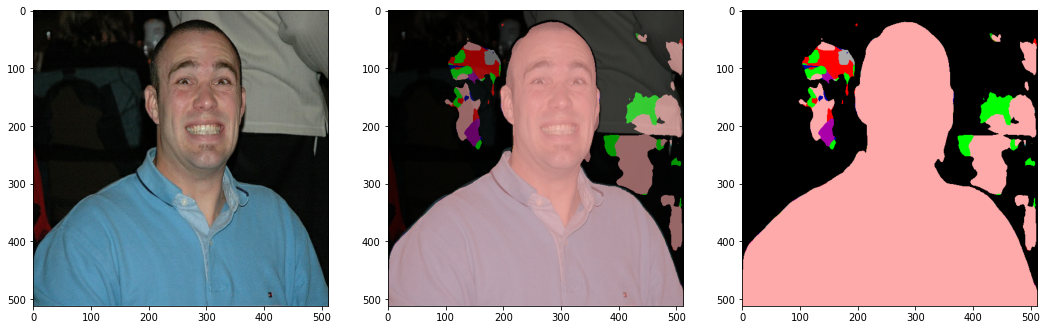

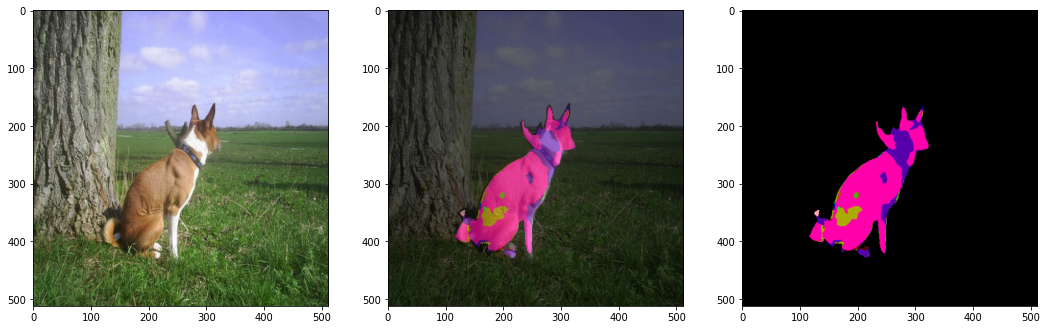

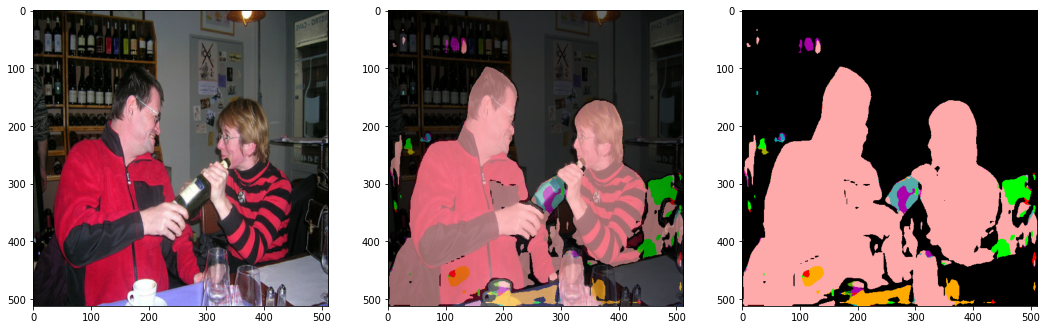

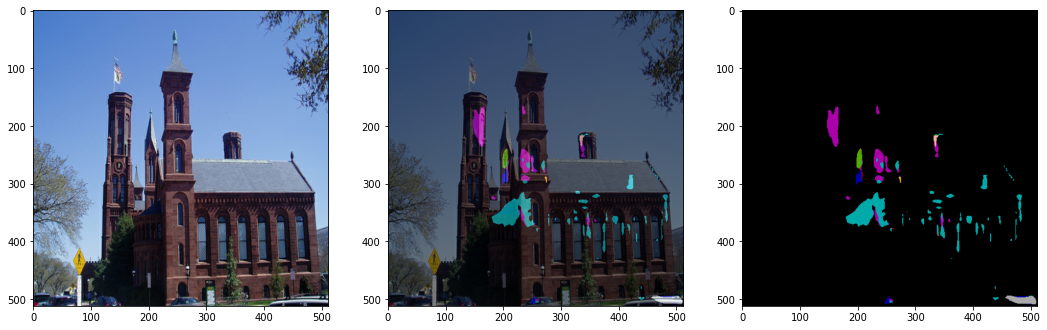

In [26]:
TRAIN_STEPS_PER_EPOCH = int(tf.math.ceil(len(train_images) / BATCH_SIZE).numpy())
VALID_STEPS_PER_EPOCH = int(tf.math.ceil(len(valid_images) / BATCH_SIZE).numpy())

callbacks = [DisplayCallback()]
             
history = model.fit(train_dataset,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS_PER_EPOCH,
                    callbacks=callbacks,
                    verbose=1,
                    epochs=EPOCHS)

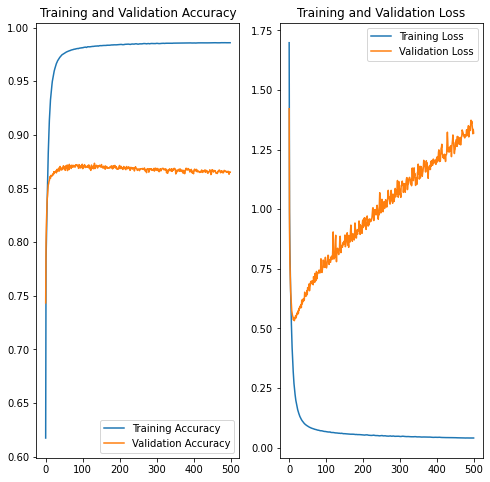

In [27]:
display_training_curves(history)

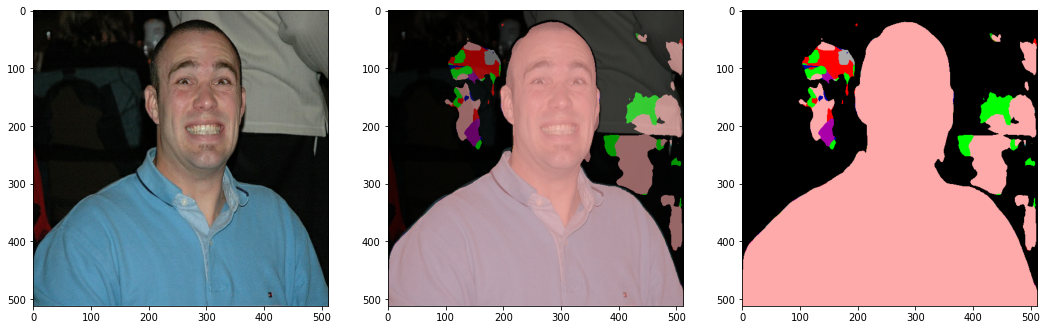

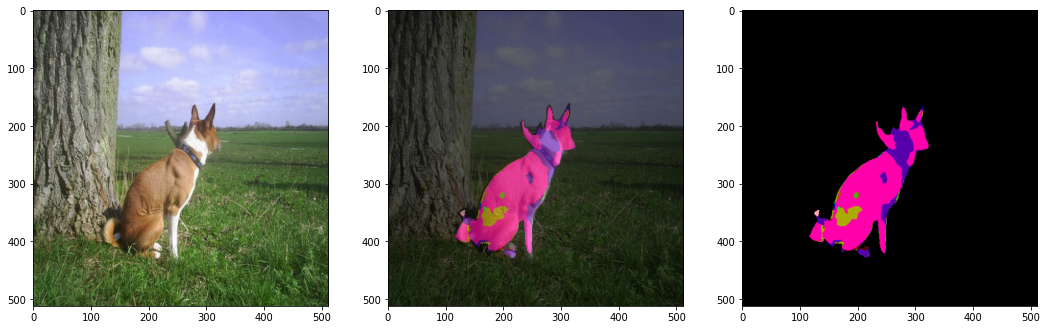

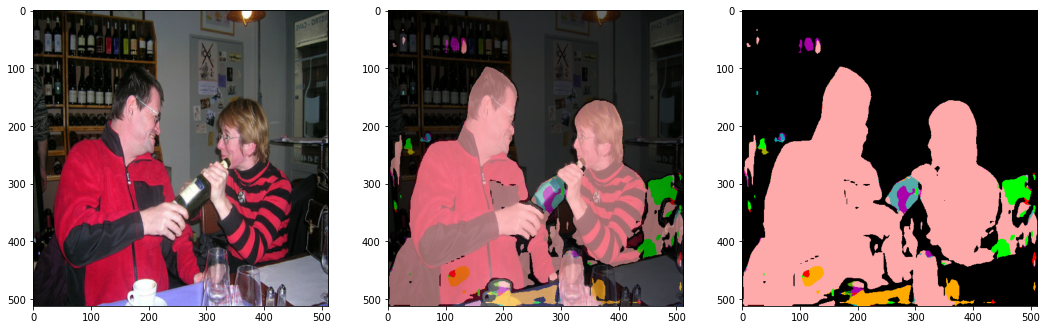

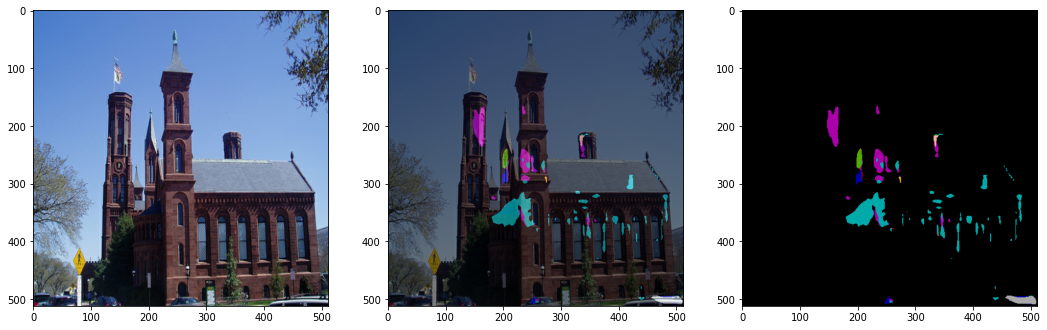

In [28]:
plot_predictions(valid_images[:4], colormap, model=model)

In [29]:
tf.saved_model.save(model, '/data/Models/segmentation/saved_model')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /data/Models/segmentation/saved_model/assets
